<a href="https://colab.research.google.com/github/Lior-Baruch/RL/blob/main/Mid_Project_tabular_RL_Minigrid_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mid Semester Project - Reinforcements Learning
Dear students,<br> this is the template notebook. Please copy it by clicking on the "File" tab and then on "Save a copy into drive".

---
<br>

### Name and ID:
Student 1:
<br>
Student 2:
<br><br>
<img src="https://raw.githubusercontent.com/Farama-Foundation/Minigrid/master/minigrid-text.png">

### https://minigrid.farama.org/

# Installs

In [1]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install gym
!pip install gym-minigrid
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install -U --no-cache-dir gdown --pre

# Imports

In [2]:
import numpy as np
import gym
from gym import logger as gymlogger
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only
import glob
import io
import base64
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
%load_ext autoreload
%autoreload 2
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame
import pyvirtualdisplay
import imageio
import IPython
import time
from tqdm import tqdm
import sys
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


# Display utils
The cell below contains the video display configuration. No need to make changes here.

In [3]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

# Env

In [4]:
from __future__ import annotations
from gym_minigrid.minigrid import COLOR_NAMES
from gym_minigrid.minigrid import Grid
from gym_minigrid.minigrid import MissionSpace
from gym_minigrid.minigrid import Door, Goal, Key, Wall, Lava, Floor
from minigrid_x import MiniGridEnv
from gym import spaces
import random


class RandomKeyMEnv_10(MiniGridEnv):
    def __init__(
        self,
        size=10,
        agent_start_pos=(1, 1),
        agent_start_dir=0,
        max_steps: int | None = None,
        **kwargs,
    ):
        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir

        mission_space = MissionSpace(mission_func=self._gen_mission)

        if max_steps is None:
            max_steps = 4 * size**2

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            # Set this to True for maximum speed
            see_through_walls=True,
            max_steps=max_steps,
            **kwargs,
        )
        self.partition_col = 3
        self.walls_init = [(self.partition_col, i) for i in range(0, self.grid.height)]
        self.goal_pos = (self.grid.width - 2, self.grid.height - 2)


    def get_pass_location(self):
      return (self.partition_col, self.pass_loc)

    def get_partition_column(self):
      return self.partition_col

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def get_k_pos(self):
      return self.key_pos

    def get_d_pos(self):
      return self.door_pos

    def _gen_grid(self, width, height):
        # Place Dor in random location within all column the partition
        self.pass_loc = random.choice([op_row for op_row in range(1, self.unwrapped.width-1)])

        # Create an empty grid
        self.grid = Grid(width, height)

        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        # Generate verical separation wall
        # for i in range(0, height):
        #     self.grid.set(5, i, Wall())


        for column, row in self.walls_init:
          self.grid.set(column, row, Wall())

        # Place Key in random location within all the free spaces left to the partition
        self.key_pos = (random.choice([k_col for k_col in range(1,self.partition_col)]), random.choice([k_row for k_row in range(2,self.unwrapped.height-1)]))
        self.door_pos = (self.partition_col, self.pass_loc)

        self.env_door = Door(COLOR_NAMES[0], is_locked=True)

        # Place the Lava
        # self.grid.set(4, 6, Lava())

        # Place the door and key
        self.grid.set(self.door_pos[0], self.door_pos[1], self.env_door)
        self.grid.set(self.key_pos[0], self.key_pos[1], Key(COLOR_NAMES[0]))
        self.goal_pos = (width - 2, height - 2)
        # Place a goal square in the bottom-right corner
        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # Place the agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "grand mission"

class RandomEmptyEnv_10(MiniGridEnv):
    def __init__(
        self,
        size=10,
        agent_start_pos=(1, 1),
        agent_start_dir = 0,
        max_steps: int | None = None,
        **kwargs,
    ):

        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir



        agent_start_x_loc =random.randint(1, 6)
        agent_start_y_loc =random.randint(1, 6)

        self.agent_start_pos = (agent_start_x_loc,agent_start_y_loc)


        mission_space = MissionSpace(mission_func=self._gen_mission)

        if max_steps is None:
            max_steps = 4 * size**2

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            # Set this to True for maximum speed
            see_through_walls=True,
            max_steps=max_steps,
            **kwargs,
        )
        self.action_space = spaces.Discrete(3)
        self.walls_init = []

        # change 21-09 for random env
        self.not_goal_loc = [(col,row) for col in range(self.unwrapped.width) for row in range(self.unwrapped.height) if row == 0 or row == (self.unwrapped.width-1) or col == 0 or col == (self.unwrapped.height-1)]
        self.not_goal_loc.append(self.agent_start_pos)
        self.goal_pos = (self.grid.width - 2, self.grid.height - 2)

    def reset(self, **kwargs):
        # Randomize start position each time environment is reset
        agent_start_x_loc = random.randint(1, 6)
        agent_start_y_loc = random.randint(1, 6)
        self.agent_start_pos = (agent_start_x_loc, agent_start_y_loc)

        self.values = [0, 1, 2, 3]
        self.agent_start_dir = random.choice(self.values)

        # Recalculate not_goal_loc as it depends on the agent's start position
        self.not_goal_loc = [(col, row) for col in range(self.unwrapped.width) for row in range(self.unwrapped.height)
                             if row == 0 or row == (self.unwrapped.width - 1) or col == 0 or col == (self.unwrapped.height - 1)]
        self.not_goal_loc.append(self.agent_start_pos)

        # Call the reset method of the parent class
        return super().reset(**kwargs)

    @staticmethod
    def _gen_mission():
        return "grand mission"

    def get_k_pos(self):
      return self.key_pos

    def get_d_pos(self):
      return self.door_pos

    def get_g_pos(self):
      return self.goal_pos

    def _gen_grid(self, width, height):
        # Create an empty grid
        self.grid = Grid(width, height)

        # Generate the surrounding walls
        self.grid.wall_rect(0, 0, width, height)

        # Generate verical separation wall
        # for i in range(0, height):
        #     self.grid.set(5, i, Wall())


        for column, row in self.walls_init:
          self.grid.set(column, row, Wall())

        self.key_pos = (6, 5)
        self.door_pos = (6, 7)

        self.env_door = Door(COLOR_NAMES[0], is_locked=True)

        # Place the Lava
        # self.grid.set(4, 6, Lava())

        # Place the door and key
        # self.grid.set(self.door_pos[0], self.door_pos[1], self.env_door)
        # self.grid.set(self.key_pos[0], self.key_pos[1], Key(COLOR_NAMES[0]))



        ## change 21-09 for random env - add player position
        # self.goal_pos = (0, 0)
        # while self.goal_pos in self.not_goal_loc:
        #   self.goal_pos = (random.randint(1, width - 2), random.randint(1, height - 2))
        self.goal_pos = random.choice([(8,1), (8,8), (1,8)])


        self.put_obj(Goal(), self.goal_pos[0], self.goal_pos[1])

        # Place a goal square in the bottom-right corner
        # self.put_obj(Goal(), width - 2, height - 2)


        # Place the agent
        if self.agent_start_pos is not None:
            self.agent_pos = self.agent_start_pos
            self.agent_dir = self.agent_start_dir
        else:
            self.place_agent()

        self.mission = "grand mission"




# Wrappers

In [5]:
import gym
from gym import spaces
from gym_minigrid.minigrid import OBJECT_TO_IDX, COLOR_TO_IDX
import copy
max_env_steps = 100

class SimFlatObsWrapper(gym.core.ObservationWrapper):
    """Fully observable gridworld returning a flat grid encoding."""

    def __init__(self, env):
        super().__init__(env)

        # Since the outer walls are always present, we remove left, right, top, bottom walls
        # from the observation space of the agent. There are 3 channels, but for simplicity
        # in this assignment, we will deal with flattened version of state.

        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=((self.env.width-2) * (self.env.height-2) * 3,),  # number of cells
            dtype='uint8'
        )
        self.unwrapped.max_steps = max_env_steps

        self.get_init_map()

    def observation(self, obs):
        # this method is called in the step() function to get the observation
        # we provide code that gets the grid state and places the agent in it
        env = self.unwrapped
        full_grid = env.grid.encode()
        full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array([
            OBJECT_TO_IDX['agent'],
            COLOR_TO_IDX['red'],
            env.agent_dir
        ])
        full_grid = full_grid[1:-1, 1:-1]   # remove outer walls of the environment (for efficiency)

        flattened_grid = full_grid.ravel()
        return flattened_grid

    def is_carrying_key(self):
        if 'Key' in str(self.unwrapped.carrying):
          return True
        return False

    def is_door_open(self):
        return self.unwrapped.env_door.is_open

    def get_position(self):
        return self.unwrapped.agent_pos

    def get_direction(self):
        return self.unwrapped.agent_dir

    def get_direction_str(self):
        return self.unwrapped.AGENT_DIR_TO_STR[self.unwrapped.agent_dir]

    def is_wall_front_pos(self):
      if 0 in self.unwrapped.front_pos or (self.unwrapped.height-1) in self.unwrapped.front_pos:
        return True
      return (tuple(self.unwrapped.front_pos) in self.unwrapped.walls_init)

    def get_goal_pos(self):
        return self.unwrapped.goal_pos

    def get_init_map(self):
      # outer walls
      map_u = [[1 if i == 0 or i == (self.unwrapped.height-1) or j == 0 or j == (self.unwrapped.width-1) else 0 for j in range(self.unwrapped.width)] for i in range(self.unwrapped.height)]
      # inner walls
      for loc in self.unwrapped.walls_init: map_u[loc[1]][loc[0]] = 1
      self.init_map = map_u

    def get_updated_map(self):
      map_up = copy.deepcopy(self.init_map)
      # agent position
      agent_col, agent_row = self.unwrapped.agent_pos
      map_up[agent_row][agent_col] = 'P'
      # goal
      curr_goal_pos = self.get_goal_pos()
      map_up[curr_goal_pos[1]][curr_goal_pos[0]] = 'G'
      return map_up

    def is_door_front_pos(self):
      return (tuple(self.unwrapped.front_pos) == self.unwrapped.get_d_pos())

    def is_key_front_pos(self):
      return (tuple(self.unwrapped.front_pos) == self.unwrapped.get_k_pos())

    def render(self, *args, **kwargs):
        """This removes the default visualization of the partially observable field of view."""
        return self.unwrapped.render()


class KeyFlatObsWrapper(gym.core.ObservationWrapper):
    """Fully observable gridworld returning a flat grid encoding."""

    def __init__(self, env):
        super().__init__(env)

        # Since the outer walls are always present, we remove left, right, top, bottom walls
        # from the observation space of the agent. There are 3 channels, but for simplicity
        # in this assignment, we will deal with flattened version of state.

        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=((self.env.width-2) * (self.env.height-2) * 3,),  # number of cells
            dtype='uint8'
        )
        self.unwrapped.max_steps = max_env_steps

        self.get_init_map()

    def observation(self, obs):
        # this method is called in the step() function to get the observation
        # we provide code that gets the grid state and places the agent in it
        env = self.unwrapped
        full_grid = env.grid.encode()
        full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array([
            OBJECT_TO_IDX['agent'],
            COLOR_TO_IDX['red'],
            env.agent_dir
        ])
        full_grid = full_grid[1:-1, 1:-1]   # remove outer walls of the environment (for efficiency)

        flattened_grid = full_grid.ravel()
        return flattened_grid

    def is_carrying_key(self):
        if 'Key' in str(self.unwrapped.carrying):
          return True
        return False

    def is_door_open(self):
        return self.unwrapped.env_door.is_open

    def get_position(self):
        return self.unwrapped.agent_pos

    def get_direction(self):
        return self.unwrapped.agent_dir

    def get_direction_str(self):
        return self.unwrapped.AGENT_DIR_TO_STR[self.unwrapped.agent_dir]

    def is_wall_front_pos(self):
      if 0 in self.unwrapped.front_pos or (self.unwrapped.height-1) in self.unwrapped.front_pos:
        return True
      return (tuple(self.unwrapped.front_pos) in self.unwrapped.walls_init)

    def get_goal_pos(self):
      return self.unwrapped.goal_pos

    def get_door_pos(self):
      return self.unwrapped.door_pos

    def get_key_pos(self):
      return self.unwrapped.key_pos

    def get_init_map(self):
      # outer walls
      map_u = [[1 if i == 0 or i == (self.unwrapped.height-1) or j == 0 or j == (self.unwrapped.width-1) else 0 for j in range(self.unwrapped.width)] for i in range(self.unwrapped.height)]
      # inner walls
      for loc in self.unwrapped.walls_init: map_u[loc[1]][loc[0]] = 1
      # map_u[self.unwrapped.width-2][self.unwrapped.height-2] = 'G'
      self.init_map = map_u

    def get_updated_map(self):
      map_up = copy.deepcopy(self.init_map)
      # agent position
      agent_col, agent_row = self.unwrapped.agent_pos
      map_up[agent_row][agent_col] = 'P'
      if not self.is_door_open():
        door_col, door_row = self.unwrapped.door_pos
        map_up[door_row][door_col] = 'D'
        if not self.is_carrying_key():
          key_col, key_row = self.unwrapped.key_pos
          map_up[key_row][key_col] = 'K'
      # goal
      curr_goal_pos = self.get_goal_pos()
      map_up[curr_goal_pos[1]][curr_goal_pos[0]] = 'G'

      return map_up

    def is_door_front_pos(self):
      return (tuple(self.unwrapped.front_pos) == self.unwrapped.get_d_pos())

    def is_key_front_pos(self):
      return (tuple(self.unwrapped.front_pos) == self.unwrapped.get_k_pos())

    def render(self, *args, **kwargs):
        """This removes the default visualization of the partially observable field of view."""
        return self.unwrapped.render()



```
# This is formatted as code
```

# RandomEmptyEnv_10

**Description**:

This environment is an empty room, and the goal of the agent is to reach the green goal square.

Agent position at begining is random.


Direction of the agent at begining is random.


Goal position could be: (8,1) or (1,8) or (8,8).

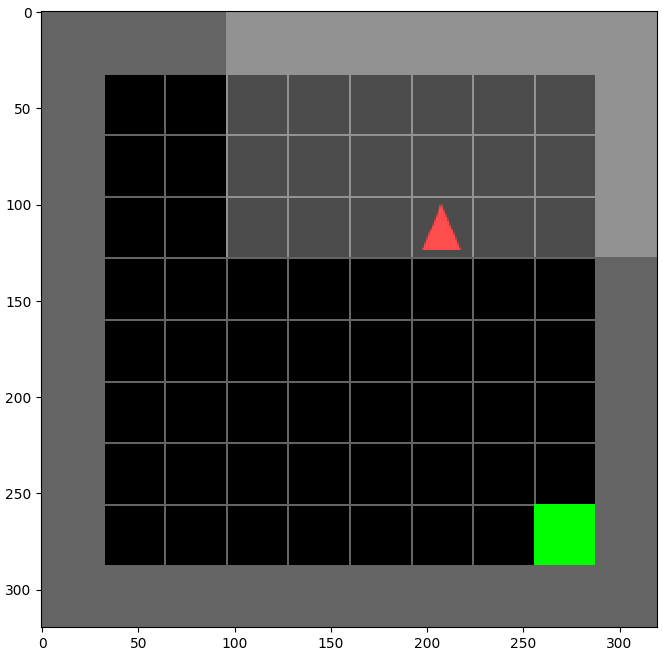

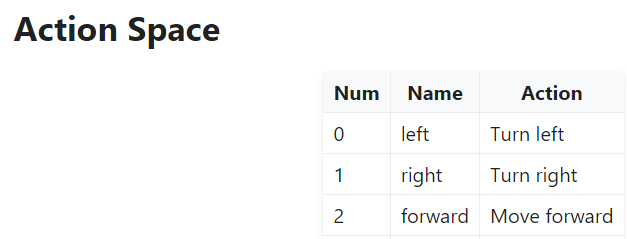

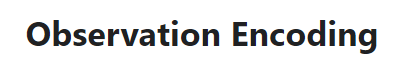

Agent Direction,
Agent Position,
Goal Position

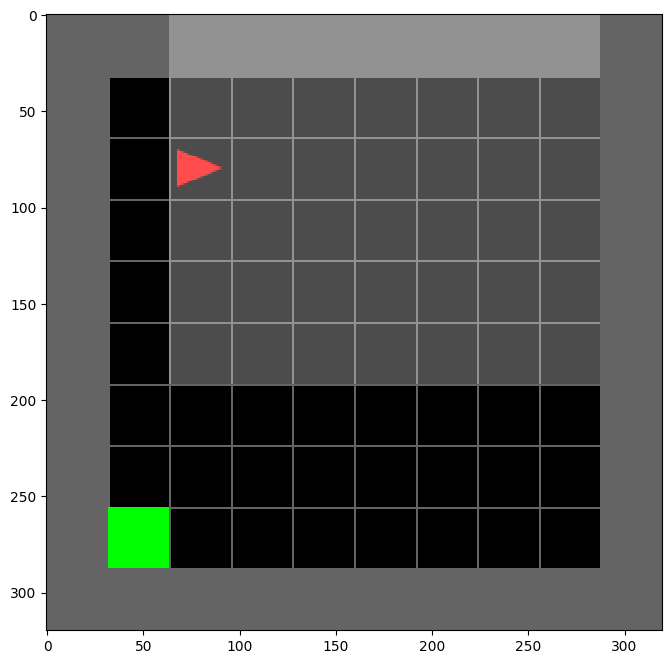

In [6]:
env = KeyFlatObsWrapper(RandomEmptyEnv_10 (render_mode='rgb_array'))
obs = env.reset()
screen = env.render()
plt.imshow(screen)

In [7]:
action_space = env.action_space
num_actions = action_space.n
print(f"Number of actions: {num_actions}")


Number of actions: 3


Map Height: 8
Map Width: 8
Agent Direction: 3
Agent Position: (1, 5)
Goal position:  (1, 8)


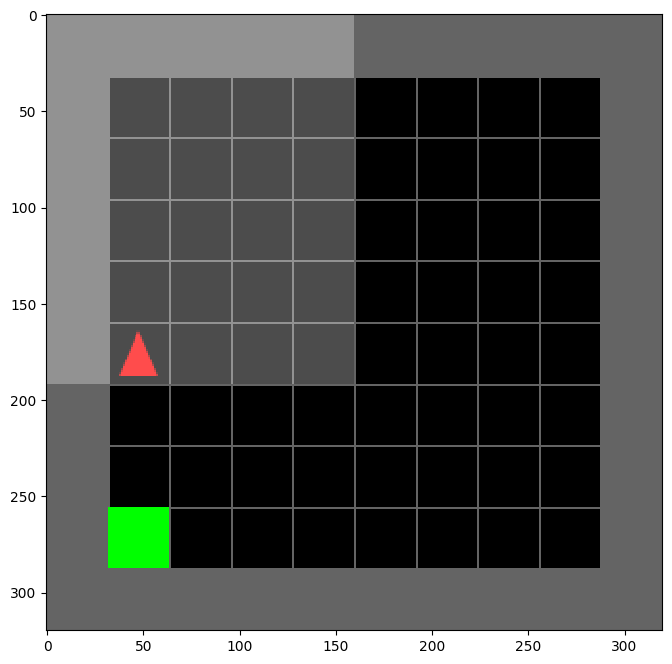

In [8]:
obs = env.reset()
# ============================================
screen = env.render()
plt.imshow(screen)
print('Map Height:', env.height-2)
print('Map Width:', env.width-2)
print('Agent Direction:', env.get_direction())
print('Agent Position:', env.get_position())
print('Goal position: ', env.get_goal_pos())

In [9]:
#Random action plus visualization
#env = KeyFlatObsWrapper(RandomEmptyEnv_10 (render_mode='rgb_array'))
obs = env.reset()
video_filename = '/content/fn.mp4'
max_steps = 100

with imageio.get_writer(video_filename, fps=10) as video:
  obs = env.reset()
  done = False
  total_reward = 0
  for step in range(max_steps):
      action = random.randint(0, num_actions - 1)
      obs, reward, done, _, _ = env.step(action)
      next_obs = obs  # Get agent's position directly from the environment
      video.append_data(env.render())
      if done:
        print("done","reward=", total_reward,"num_of_steps=",step)
        break
embed_mp4(video_filename)

# RandomKeyMEnv_10

###Description

This environment has a key that the agent must pick up in order to unlock a goal and then get to the green goal square.

Wall is always in the third column

Key is always in the left part (left to the door)

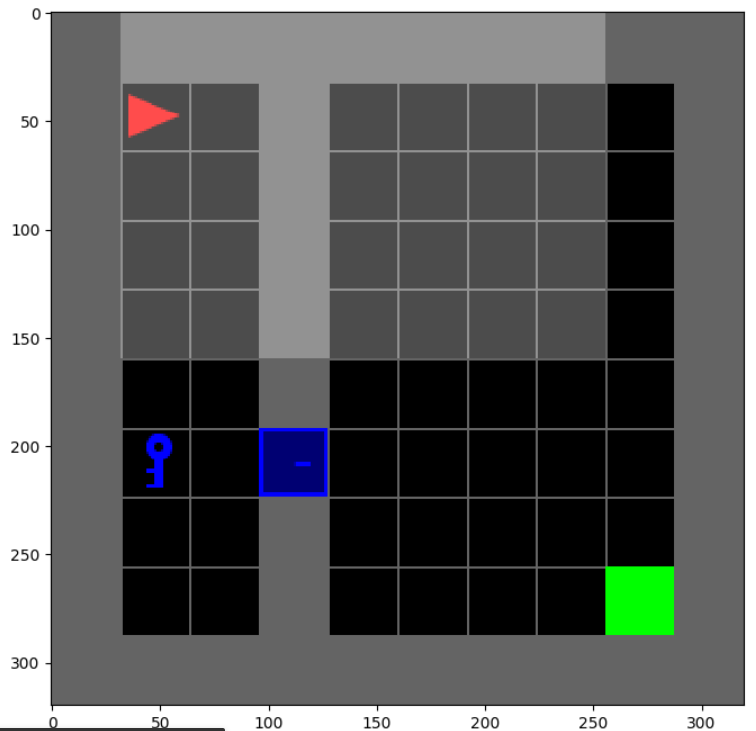

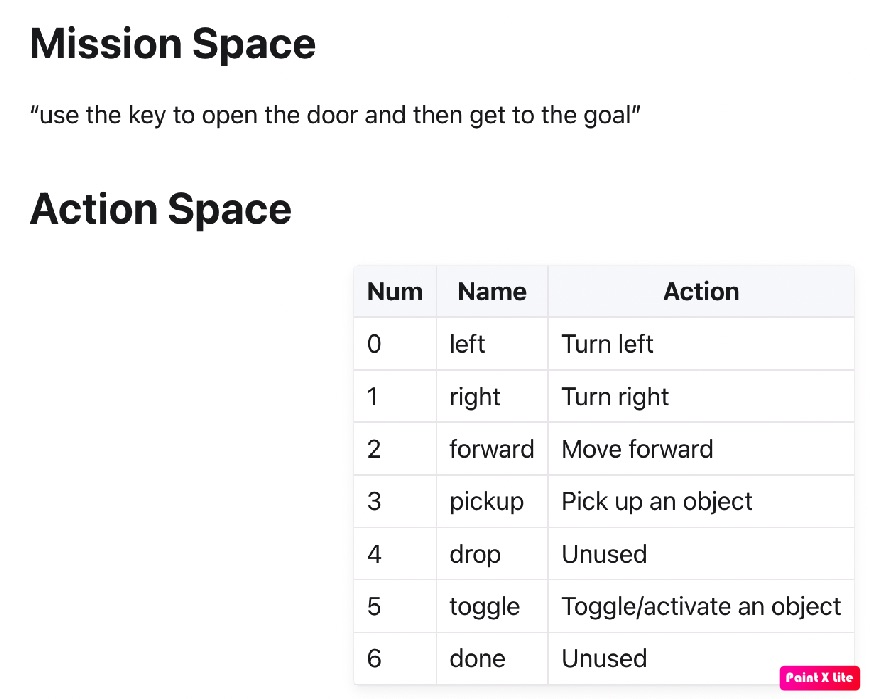

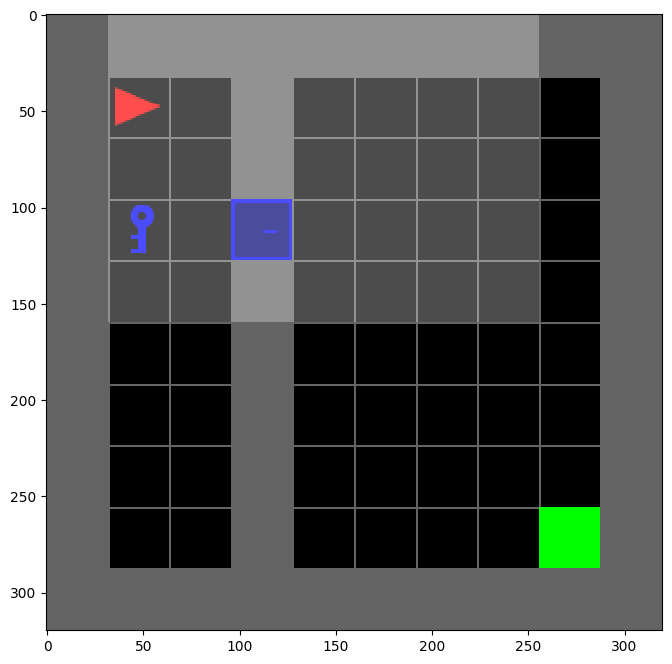

In [10]:
#=============== DO NOT DELETE ===============
# random.seed(42)
env = KeyFlatObsWrapper(RandomKeyMEnv_10 (render_mode='rgb_array'))
#env = KeyFlatObsWrapper(KeyMazeEnv_10(render_mode='rgb_array'))

obs = env.reset()
# ============================================
screen = env.render()
plt.imshow(screen)

In [11]:
action_space = env.action_space
num_actions = action_space.n
print(f"Number of actions: {num_actions}")

Number of actions: 7


Door is opened? :  False
carrying Key? :  False
Agent Direction: 0
Agent Position: (1, 1)
Is there a wall in front of the Agent? :  False
Goal position:  (8, 8)
Key Position: (2, 6)
Door Position: (3, 2)


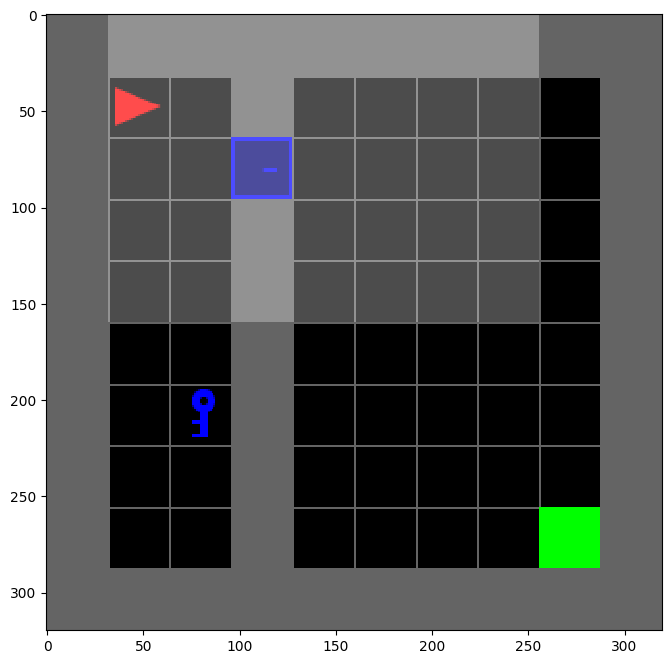

In [12]:
env = KeyFlatObsWrapper(RandomKeyMEnv_10 (render_mode='rgb_array'))
obs = env.reset()
# ============================================
screen = env.render()
plt.imshow(screen)
print('Door is opened? : ', env.is_door_open())
print('carrying Key? : ',env.is_carrying_key())
print('Agent Direction:', env.get_direction())
print('Agent Position:', env.get_position())
print('Is there a wall in front of the Agent? : ', env.is_wall_front_pos())
print('Goal position: ', env.get_goal_pos())
print('Key Position:', env.get_k_pos())
print('Door Position:', env.get_d_pos())

# Start of our code

In [13]:
# SEED = 42
random.seed(42)
np.random.seed(42)

## General methods

In [45]:
# Function to convert state into a hashable type
def hash_state(state):
    # if ndarray, convert to tuple
    if isinstance(state, np.ndarray):
        state = tuple(state)
    else:
        print('Warning: state is not a numpy array, bro you are in trouble (evil laugh)') # just for fun :D
    return state

# Function to implement epsilon-greedy policy
def epsilon_greedy_policy(Q, hashed_state, epsilon, num_actions, avoid_actions=[]):
    legal_actions = [i for i in range(num_actions) if i not in avoid_actions] # legal actions are those that are not in avoid_actions
    if np.random.random() < epsilon:
        action_to_take = np.random.choice(legal_actions)
    else:
        action_values = Q[hashed_state]
        action_to_take = np.argmax(action_values)
        if action_to_take in avoid_actions: # if the action to take is in avoid_actions, choose randomly from legal actions
            action_to_take = np.random.choice(legal_actions)
    return action_to_take

# Function that returns the mean value of every amount_to_avg elements in a list
def mean_list(num_list, amount_to_avg):
    # return and avarage list of every amount_to_avg elements
    avg_list = [np.mean(num_list[i:i+amount_to_avg]) for i in range(0, len(num_list), amount_to_avg)]
    return avg_list

# Function to display the reward and number of steps history
def display_reward_and_steps(reward_history, num_steps_history, amount_to_avg=50, figsize=(8, 3)):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    # plot the reward history
    ax1.plot(np.arange(0, len(reward_history), amount_to_avg), mean_list(reward_history, amount_to_avg))

    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward')
    ax1.set_title(f"Reward History averaged over {amount_to_avg} episodes")

    # plot the number of steps history
    ax2.plot(np.arange(0, len(num_steps_history), amount_to_avg), mean_list(num_steps_history, amount_to_avg))
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Number of steps')
    ax2.set_title(f"Number of Steps History averaged over {amount_to_avg} episodes")

    plt.tight_layout()
    plt.show()

# Function to display the reward and number of steps history for each set of hyperparameters
def display_reward_and_steps_dict(reward_history_dict, num_steps_history_dict, amount_to_avg=50, figsize=(10, 3)):
    # loop over the keys in the dictionary (each key is a different set of hyperparameters)
    for key in reward_history_dict.keys(): # they have the same keys
        print(f'Hyperparameters: {key}')
        display_reward_and_steps(reward_history_dict[key], num_steps_history_dict[key], amount_to_avg, figsize)
        print('\n')

# Function to infer the goal with a given policy
def infer_goal(env, policy, max_steps=1000, show_init_state=False, avoid_actions=[]):
    # reset the environment
    obs = env.reset()[0]
    done = False
    total_reward = 0
    legal_actions = [i for i in range(env.action_space.n) if i not in avoid_actions]
    # show the initial state
    if show_init_state:
        screen = env.render()
        plt.imshow(screen)
    # run the environment until done or max_steps
    for step in range(max_steps):
        hashed_state = hash_state(obs)
        if hashed_state in policy:
            # get the action from the policy
            action = policy[hashed_state]
        else:
            action = np.random.choice(legal_actions)

        # take a step in the environment
        obs, reward, done, _, _ = env.step(action)
        # add the reward to the total
        total_reward += reward
        # if done, break
        if done:
            break
    # return the done flag, total reward, and number of steps
    return done, total_reward, step

# Function to infer the goal with a given policy and save a video
def infer_goal_with_video(env, policy, max_steps=1000, video_filename='/content/fn.mp4', avoid_actions=[]):
    with imageio.get_writer(video_filename, fps=10) as video:
        obs = env.reset()[0]
        done = False
        total_reward = 0
        legal_actions = [i for i in range(env.action_space.n) if i not in avoid_actions]
        # run the environment until done or max_steps
        for step in range(max_steps):
            hashed_state = hash_state(obs)
            if hashed_state in policy:
                # get the action from the policy
                action = policy[hashed_state]
            else:
                action = np.random.choice(legal_actions)
            # take a step in the environment
            obs, reward, done, _, _ = env.step(action)
            # add the reward to the total
            total_reward += reward
            video.append_data(env.render())
            # if done, break
            if done:
                break
    # return the done flag, total reward, and number of steps
    return done, total_reward, step


# Function to evaluate the policy
def evaluate_policy(env, policy, num_episodes=100, max_steps=1000):
    # initialize the total reward and total number of steps
    total_reward = 0
    total_steps = 0
    total_done = 0
    # loop over the episodes
    for _ in range(num_episodes):
        # infer the goal with the policy
        done, reward, steps = infer_goal(env, policy, max_steps)
        # add the reward and number of steps to the totals
        total_reward += reward
        total_steps += steps
        if done:
            total_done += 1
    # return the average reward and average number of steps
    avg_reward = total_reward / num_episodes
    avg_steps = total_steps / num_episodes
    avg_done = total_done / num_episodes
    return avg_reward, avg_steps, avg_done

# Function to get the best policy from a dictionary of policies
def get_best_policy_from_policy_dict(env, policy_dict, num_episodes=100, max_steps=1000):
    best_policy = None
    best_avg_reward = -np.inf
    best_avg_steps = np.inf
    for key, policy in policy_dict.items():
        avg_reward, avg_steps, avg_done = evaluate_policy(env, policy, num_episodes, max_steps)
        if avg_reward >= best_avg_reward and avg_steps <= best_avg_steps:
            best_policy = policy
            best_avg_reward = avg_reward
            best_avg_steps = avg_steps
            best_avg_done = avg_done
            best_key = key
    return best_policy, best_avg_reward, best_avg_steps, best_avg_done, best_key

## Monte Carlo

- `generate_episode`: This function generates an episode by following an epsilon-greedy policy. It returns a list of tuples `(state, action, reward)`.

- `update_Q`: This function updates the Q-table using the episode generated by the `generate_episode` function.

- `mc_control_epsilon_greedy`: This function implements the Monte Carlo control algorithm using an epsilon-greedy policy. It returns the policy, Q-table, rewards, and number of steps for each episode.


In [15]:
import sys
from collections import defaultdict

# Function to generate an episode following the epsilon-greedy policy
def generate_episode(env, Q, epsilon, max_steps, avoid_actions=[], reward_shaping=False):
    # initialize the episode list, reset the environment, and get the initial state and hashed state
    episode = []
    state = env.reset()[0]
    hashed_state = hash_state(state)
    # loop over the max_steps
    for t in range(max_steps):
        # get info before action
        prev_is_door_open = env.is_door_open()
        # get the action following the epsilon-greedy policy and take a step in the environment
        action = epsilon_greedy_policy(Q, hashed_state, epsilon, env.action_space.n, avoid_actions)
        next_state, reward, done, _, _ = env.step(action)
        # get info after action
        is_door_open = env.is_door_open()
        # reward shaping
        if reward_shaping:
            if not prev_is_door_open and is_door_open:
                reward += 0.001
            if prev_is_door_open and not is_door_open:
                reward -= 0.001

        # append the state, action, and reward to the episode
        episode.append((hashed_state, action, reward))
        if done:
            break
        # update the current state and hashed state
        state = next_state
        hashed_state = hash_state(state)
    return episode

# Function to update the Q-table based on the generated episode
def update_Q(episode, Q, returns_sum, state_action_count, gamma):
    # get the states, actions, and rewards in the episode
    states, actions, rewards = zip(*episode)
    num_of_steps = len(rewards) + 1
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(num_of_steps)])
    # update the sum of the returns, and the count of returns for each state-action pair in the episode
    for i, (state , action) in enumerate(zip(states, actions)):
        # calculate i_th discounted return
        i_discounted_rewards = rewards[i:] * discounts[:-(1 + i)]
        # update the sum of the returns
        returns_sum[state][action] += sum(i_discounted_rewards)
        # update the count of returns
        state_action_count[state][action] += 1.0
        # update the Q-table
        Q[state][action] = returns_sum[state][action] / state_action_count[state][action]
    return Q

# Main function to implement the Monte Carlo Control with Epsilon-Greedy policy
def mc_control_epsilon_greedy(env, num_episodes, epsilon, gamma=1.0, max_env_steps=1000,
                               print_every=100, epsilon_decay=1.0, avoid_actions=[], reward_shaping=False):
    # init history
    reward_history = []
    num_steps_history = []
    # initialize the Q-table, returns sum, and state-action count
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    state_action_count = defaultdict(lambda: np.zeros(env.action_space.n))

    # loop over the episodes
    for i in tqdm(range(num_episodes)):
        # generate an episode and update the Q-table
        episode = generate_episode(env, Q, epsilon, max_env_steps, avoid_actions, reward_shaping)
        Q = update_Q(episode, Q, returns_sum, state_action_count, gamma)
        # Calculate total reward for the episode and append into the reward_history list
        curr_reward = sum([reward for _, _, reward in episode])
        reward_history.append(curr_reward)
        # append the number of steps in the episode to the num_steps_history list
        num_steps_history.append(len(episode))

        # Print out the total reward and number of steps in the episode every 'print_every' episodes
        if i % print_every == 0 or i == num_episodes - 1:
            print(f"\rEpisode {i}/{num_episodes}. Avg reward: {np.mean(reward_history[-print_every:])}, Avg steps: {np.mean(num_steps_history[-print_every:])}, Epsilon: {epsilon}", end="")
            sys.stdout.flush()
        # decay epsilon
        epsilon *= epsilon_decay

    # get the policy from the Q-table (for each state, get the action with the highest value)
    policy = {state: np.argmax(values) for state, values in Q.items()}
    # return the policy, Q-table, and the reward history
    return policy, Q, reward_history, num_steps_history

## SARSA

- `sarsa`: This function implements the SARSA algorithm, returning policy, Q-table, rewards history, and number of steps history.

In [16]:
# Function to implement the SARSA algorithm
def sarsa(env, num_episodes, epsilon, alpha, gamma=1.0, max_env_steps=1000,
           print_every=100, epsilon_decay=1.0, avoid_actions=[], reward_shaping=False):
    # init history and Q-table
    reward_history = []
    num_steps_history = []
    done_history = []
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # loop over episodes
    for i in tqdm(range(num_episodes)):
        # reset the environment
        state = env.reset()[0]
        # get the hashed state
        hashed_state = hash_state(state)
        # get the action from the epsilon-greedy policy
        action = epsilon_greedy_policy(Q, hashed_state, epsilon, env.action_space.n,
                                        avoid_actions=avoid_actions)
        done = False
        total_reward = 0
        # loop over steps
        for t in range(max_env_steps):
            # get info before action
            prev_is_door_open = env.is_door_open()
            # take a step in the environment
            next_state, reward, done, _, _ = env.step(action)
            # get info after action
            curr_is_door_open = env.is_door_open()

            # reward shaping
            if reward_shaping:
                if not prev_is_door_open and curr_is_door_open:
                    reward += 0.001
                if prev_is_door_open and not curr_is_door_open:
                    reward -= 0.001

            # add the reward to the total
            total_reward += reward
            # get the next hashed state
            next_hashed_state = hash_state(next_state)
            # get the next action from the epsilon-greedy policy
            next_action = epsilon_greedy_policy(Q, next_hashed_state, epsilon, env.action_space.n)
            # update the Q-table
            td_target = reward + gamma * Q[next_hashed_state][next_action] # curr target
            td_delta = td_target - Q[hashed_state][action] # curr delta
            Q[hashed_state][action] += alpha * td_delta # update
            # update the state and action
            state = next_state
            hashed_state = next_hashed_state
            action = next_action
            # if done, break
            if done:
                break
        # append the total reward to the reward history
        reward_history.append(total_reward)
        num_steps_history.append(t)
        done_history.append(done)
        # Print out the total reward every 100 episodes
        if i % print_every == 0 or i == num_episodes - 1:
            print(f"\rEpisode {i}/{num_episodes}. avg done: {(np.mean(done_history[-print_every:]))}, Avg reward: {format(np.mean(reward_history[-print_every:]), '.3f')}, Avg steps: {format(np.mean(num_steps_history[-print_every:]), '.3f')}, epsilon: {format(epsilon, '.3f')}", end="")
            sys.stdout.flush()
        # decay epsilon
        epsilon *= epsilon_decay

    # return the Q-table and the reward history
    policy = {state: np.argmax(values) for state, values in Q.items()}
    return policy, Q, reward_history, num_steps_history


## Q-Learning

- `q_learning`: This function implements the Q-Learning algorithm, returning policy, Q-table, rewards history, and number of steps history.

In [17]:
# Function to implement the Q-learning algorithm (like SARSA but with max over next state-action pairs)
def q_learning(env, num_episodes, epsilon, alpha, gamma=1.0, max_env_steps=1000,
                    print_every=100, epsilon_decay=1.0, avoid_actions=[],reward_shaping=False):
    # init history and Q-table
    reward_history = []
    num_steps_history = []
    done_history = []
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # loop over episodes
    for i in tqdm(range(num_episodes)):
        # reset the environment
        state = env.reset()[0]
        # get the hashed state
        hashed_state = hash_state(state)
        done = False
        total_reward = 0
        # loop over steps
        for t in range(max_env_steps):
            # get info before action for reward shaping
            prev_is_door_open = env.is_door_open()

           # get the action from the epsilon-greedy policy (avoid actions)
            action = epsilon_greedy_policy(Q, hashed_state, epsilon, env.action_space.n, avoid_actions=avoid_actions)
            # take a step in the environment
            next_state, reward, done, _, _ = env.step(action)

            # get info after action for reward shaping
            curr_is_door_open = env.is_door_open()

            # reward shaping
            if reward_shaping:
                if not prev_is_door_open and curr_is_door_open:
                    reward += 0.001
                if prev_is_door_open and not curr_is_door_open:
                    reward += -0.001

            # add the reward to the total
            total_reward += reward
            # get the next hashed state
            next_hashed_state = hash_state(next_state)
            # update the Q-table
            best_next_action = np.argmax(Q[next_hashed_state]) # best action
            td_target = reward + gamma * Q[next_hashed_state][best_next_action] # curr target
            td_delta = td_target - Q[hashed_state][action] # curr delta
            Q[hashed_state][action] += alpha * td_delta # update
            # update the state
            state = next_state
            hashed_state = next_hashed_state
            # if done, break
            if done:
                break
        # append the total reward to the reward history
        reward_history.append(total_reward)
        num_steps_history.append(t)
        done_history.append(done)
        # Print out the total reward every 100 episodes
        if i % print_every == 0:
            print(f"\rEpisode {i}/{num_episodes}. avg done: {(np.mean(done_history[-print_every:]))}, Avg reward: {format(np.mean(reward_history[-print_every:]), '.3f')}, Avg steps: {format(np.mean(num_steps_history[-print_every:]), '.3f')}, epsilon: {format(epsilon, '.3f')}", end="")
            sys.stdout.flush()
        # decay epsilon after each episode
        epsilon *= epsilon_decay

    # return the Q-table and the reward history
    policy = {state: np.argmax(values) for state, values in Q.items()}
    return policy, Q, reward_history, num_steps_history

## Grid Search

In [18]:
# monte carlo grid search for empty env
def grid_search_mc(env, num_episodes=100, max_steps=1000, epsilons=[1], gammas=[0.99],
                    epsilon_decay=0.999, print_every=500, avoid_actions=[], reward_shaping=False):
    # initialize the history
    policy_dict = {}
    Q_dict = {}
    reward_history_dict = {}
    num_steps_history_dict = {}


    # loop over the hyperparameters
    for epsilon in epsilons:
        for gamma in gammas:
            print(f"Training for epsilon={epsilon}, gamma={gamma}")
            policy, Q, reward_history, num_steps_history = mc_control_epsilon_greedy(env, num_episodes, epsilon, gamma, max_steps, epsilon_decay=epsilon_decay,
                                                                                      print_every=print_every, avoid_actions=avoid_actions, reward_shaping=reward_shaping)
            print(f"\nDone training for epsilon={epsilon}, gamma={gamma}\n")
            # store the policy, Q-table, reward history, and number of steps history
            policy_dict[(epsilon, gamma)] = policy
            Q_dict[(epsilon, gamma)] = Q
            reward_history_dict[(epsilon, gamma)] = reward_history
            num_steps_history_dict[(epsilon, gamma)] = num_steps_history
    # return the dictionaries for user to explore the results and choose the best policy
    return policy_dict, Q_dict, reward_history_dict, num_steps_history_dict

# sarsa and q-learning grid search for empty env
def grid_search_TD(env, num_episodes=100, max_steps=1000, epsilons=[1], gammas=[0.99], alphas=[0.1], type='sarsa',
                    epsilon_decay=0.999, print_every=500, avoid_actions=[], reward_shaping=False):
    # initialize the history
    policy_dict = {}
    Q_dict = {}
    reward_history_dict = {}
    num_steps_history_dict = {}


    # loop over the hyperparameters
    for epsilon in epsilons:
        for gamma in gammas:
            for alpha in alphas:
                print(f"Training for epsilon={epsilon}, gamma={gamma}, alpha={alpha}")
                if type == 'sarsa':
                    policy, Q, reward_history, num_steps_history = sarsa(env, num_episodes, epsilon, alpha, gamma, max_steps,
                                                                          epsilon_decay=epsilon_decay, print_every=print_every, avoid_actions=avoid_actions, reward_shaping=reward_shaping)
                else:
                    policy, Q, reward_history, num_steps_history = q_learning(env, num_episodes, epsilon, alpha, gamma, max_steps,
                                                                               epsilon_decay=epsilon_decay, print_every=print_every, avoid_actions=avoid_actions, reward_shaping=reward_shaping)
                print(f"\nDone training for epsilon={epsilon}, gamma={gamma}, alpha={alpha}\n")
                # store the policy, Q-table, reward history, and number of steps history
                policy_dict[(epsilon, gamma, alpha)] = policy
                Q_dict[(epsilon, gamma, alpha)] = Q
                reward_history_dict[(epsilon, gamma, alpha)] = reward_history
                num_steps_history_dict[(epsilon, gamma, alpha)] = num_steps_history
    # return the dictionaries for user to explore the results and choose the best policy
    return policy_dict, Q_dict, reward_history_dict, num_steps_history_dict


## Performe grid search on Empty Environment

- define hyperparameters
- perform grid search on empty environment for each algorithm
- plot the results
- choose the best hyperparameters for each algorithm
- show inference on the best policy for each algorithm
- compare best policies for each algorithm and choose the best one

- define hyperparameters

In [19]:
# Define hyperparameters for MC, SARSA and Q-learning grid search
num_episodes = 3000
max_steps = 1000
epsilons = [1] # [0.5, 1]
gammas = [0.99] # [0.9, 0.99]
alphas = [0.2] # [0.1, 0.2]
epsilon_decay = 0.999
print_every = int(num_episodes / 3)

# Initialize the environment
empty_env = SimFlatObsWrapper(RandomEmptyEnv_10 (render_mode='rgb_array'))

- perform grid search on empty environment for each algorithm

In [20]:
# Perform the grid search for MC on the empty environment
print("Monte Carlo Control")
policy_dict_mc_empty, Q_dict_mc_empty, reward_history_dict_mc_empty, num_steps_history_dict_mc_empty = grid_search_mc(
    empty_env,
    num_episodes=num_episodes,
    max_steps=max_steps,
    epsilons=epsilons,
    gammas=gammas,
    epsilon_decay=epsilon_decay,
    print_every=print_every,
    avoid_actions=[],
    reward_shaping=False
)

# Perform the grid search for SARSA on the empty environment
print("SARSA")
policy_dict_sarsa_empty, Q_dict_sarsa_empty, reward_history_dict_sarsa_empty, num_steps_history_dict_sarsa_empty = grid_search_TD(
    empty_env,
    num_episodes=num_episodes,
    max_steps=max_steps,
    epsilons=epsilons,
    gammas=gammas,
    alphas=alphas,
    type='sarsa',
    epsilon_decay=epsilon_decay,
    print_every=print_every,
    avoid_actions=[],
    reward_shaping=False
)

# Perform the grid search for Q-learning on the empty environment
print("Q-learning")
policy_dict_q_learning_empty, Q_dict_q_learning_empty, reward_history_dict_q_learning_empty, num_steps_history_dict_q_learning_empty = grid_search_TD(
    empty_env,
    num_episodes=num_episodes,
    max_steps=max_steps,
    epsilons=epsilons,
    gammas=gammas,
    alphas=alphas,
    type='q_learning',
    epsilon_decay=epsilon_decay,
    print_every=print_every,
    avoid_actions=[],
    reward_shaping=False
)

Monte Carlo Control
Training for epsilon=1, gamma=0.99


  0%|          | 0/3000 [00:00<?, ?it/s]

Episode 0/3000. Avg reward: 1.0, Avg steps: 914.0, Epsilon: 1

 33%|███▎      | 997/3000 [01:32<00:35, 56.66it/s]

Episode 1000/3000. Avg reward: 0.992, Avg steps: 93.607, Epsilon: 0.3676954247709635

 67%|██████▋   | 1996/3000 [01:49<00:27, 36.73it/s]

Episode 2000/3000. Avg reward: 1.0, Avg steps: 25.607, Epsilon: 0.1351999253974994

100%|█████████▉| 2997/3000 [02:09<00:00, 64.59it/s]

Episode 2999/3000. Avg reward: 0.999, Avg steps: 30.07, Epsilon: 0.04976215615419044

100%|██████████| 3000/3000 [02:09<00:00, 23.22it/s]



Done training for epsilon=1, gamma=0.99

SARSA
Training for epsilon=1, gamma=0.99, alpha=0.2


  0%|          | 0/3000 [00:00<?, ?it/s]

Episode 0/3000. avg done: 1.0, Avg reward: 1.000, Avg steps: 710.000, epsilon: 1.000

 33%|███▎      | 990/3000 [00:47<00:20, 99.25it/s] 

Episode 1000/3000. avg done: 0.991, Avg reward: 0.991, Avg steps: 76.226, epsilon: 0.368

 66%|██████▋   | 1994/3000 [00:55<00:11, 89.17it/s]

Episode 2000/3000. avg done: 1.0, Avg reward: 1.000, Avg steps: 12.571, epsilon: 0.135

100%|█████████▉| 2990/3000 [01:04<00:00, 156.50it/s]

Episode 2999/3000. avg done: 1.0, Avg reward: 1.000, Avg steps: 9.974, epsilon: 0.050

100%|██████████| 3000/3000 [01:04<00:00, 46.72it/s] 



Done training for epsilon=1, gamma=0.99, alpha=0.2

Q-learning
Training for epsilon=1, gamma=0.99, alpha=0.2


  0%|          | 0/3000 [00:00<?, ?it/s]

Episode 0/3000. avg done: 0.0, Avg reward: 0.000, Avg steps: 999.000, epsilon: 1.000

 33%|███▎      | 987/3000 [00:43<00:20, 99.35it/s]

Episode 1000/3000. avg done: 0.993, Avg reward: 0.993, Avg steps: 67.895, epsilon: 0.368

 66%|██████▋   | 1988/3000 [00:52<00:06, 147.63it/s]

Episode 2000/3000. avg done: 1.0, Avg reward: 1.000, Avg steps: 12.978, epsilon: 0.135

100%|██████████| 3000/3000 [00:59<00:00, 50.26it/s] 


Done training for epsilon=1, gamma=0.99, alpha=0.2



- plot the results

Monte Carlo Control
Hyperparameters: (1, 0.99)


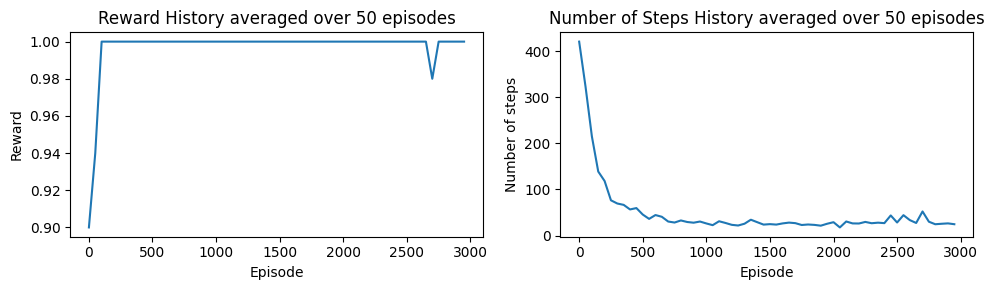



SARSA
Hyperparameters: (1, 0.99, 0.2)


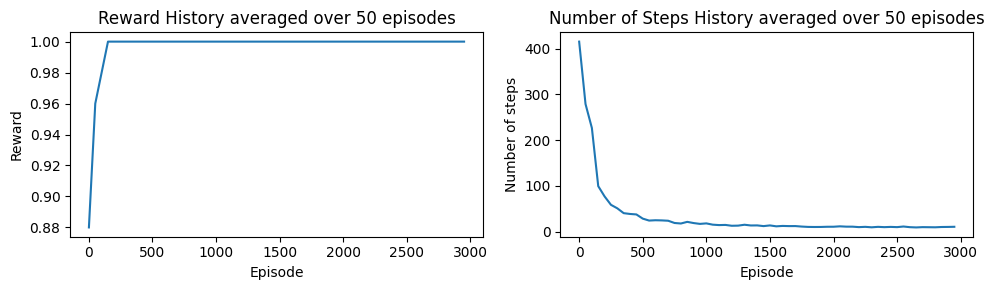



Q-learning
Hyperparameters: (1, 0.99, 0.2)


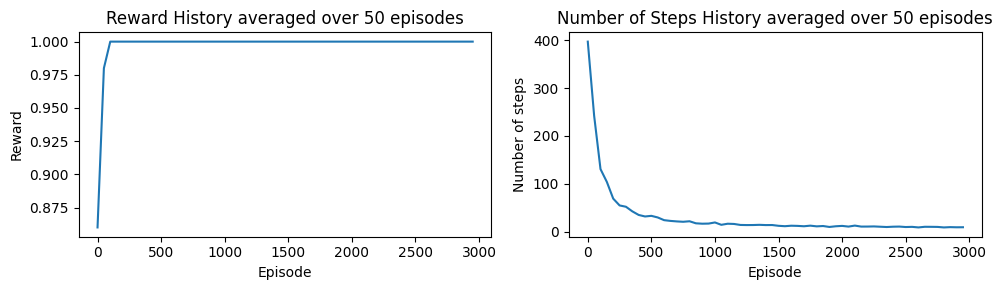

In [21]:
display_plots = True
# Display the reward and number of steps history for each set of hyperparameters
if display_plots:
    print("Monte Carlo Control")
    display_reward_and_steps_dict(reward_history_dict_mc_empty, num_steps_history_dict_mc_empty, amount_to_avg=50)
    print("SARSA")
    display_reward_and_steps_dict(reward_history_dict_sarsa_empty, num_steps_history_dict_sarsa_empty, amount_to_avg=50)
    print("Q-learning")
    display_reward_and_steps_dict(reward_history_dict_q_learning_empty, num_steps_history_dict_q_learning_empty, amount_to_avg=50)



- choose the best hyperparameters for each algorithm

In [22]:
# Get the best policy for each algorithm
best_policy_mc_empty, best_avg_reward_mc_empty, best_avg_steps_mc_empty, best_avg_done_mc_empty, best_key_mc_empty = get_best_policy_from_policy_dict(
    empty_env, policy_dict_mc_empty, num_episodes=100, max_steps=1000
)
best_policy_sarsa_empty, best_avg_reward_sarsa_empty, best_avg_steps_sarsa_empty, best_avg_done_sarsa_empty, best_key_sarsa_empty = get_best_policy_from_policy_dict(
    empty_env, policy_dict_sarsa_empty, num_episodes=100, max_steps=1000
)
best_policy_q_learning_empty, best_avg_reward_q_learning_empty, best_avg_steps_q_learning_empty, best_avg_done_q_learning_empty, best_key_q_learning_empty = get_best_policy_from_policy_dict(
    empty_env, policy_dict_q_learning_empty, num_episodes=100, max_steps=1000
)

# Print the best hyperparameters for each algorithm
print("Monte Carlo Control")
print(f"Best hyperparameters: {best_key_mc_empty} = (epsilon, gamma)")
print(f"Best average reward: {best_avg_reward_mc_empty}")
print(f"Best average number of steps: {best_avg_steps_mc_empty}")
print(f"Best average done: {best_avg_done_mc_empty}")
print("\nSARSA")
print(f"Best hyperparameters: {best_key_sarsa_empty} = (epsilon, gamma, alpha)")
print(f"Best average reward: {best_avg_reward_sarsa_empty}")
print(f"Best average number of steps: {best_avg_steps_sarsa_empty}")
print(f"Best average done: {best_avg_done_sarsa_empty}")
print("\nQ-learning")
print(f"Best hyperparameters: {best_key_q_learning_empty} = (epsilon, gamma, alpha)")
print(f"Best average reward: {best_avg_reward_q_learning_empty}")
print(f"Best average number of steps: {best_avg_steps_q_learning_empty}")
print(f"Best average done: {best_avg_done_q_learning_empty}")

Monte Carlo Control
Best hyperparameters: (1, 0.99) = (epsilon, gamma)
Best average reward: 0.82
Best average number of steps: 187.85
Best average done: 0.82

SARSA
Best hyperparameters: (1, 0.99, 0.2) = (epsilon, gamma, alpha)
Best average reward: 1.0
Best average number of steps: 8.84
Best average done: 1.0

Q-learning
Best hyperparameters: (1, 0.99, 0.2) = (epsilon, gamma, alpha)
Best average reward: 1.0
Best average number of steps: 8.6
Best average done: 1.0


- show inference on the best policy for each algorithm

In [46]:
# Show video of the best policy for MC Empty
video_filename_mc_empty = '/content/mc_empty.mp4'
done, total_reward, num_steps = infer_goal_with_video(empty_env, best_policy_mc_empty, video_filename=video_filename_mc_empty)
print(f"Monte Carlo Control with Epsilon-Greedy policy: Done={done}, Total Reward={total_reward}, Number of Steps={num_steps}")
embed_mp4(video_filename_mc_empty)

Monte Carlo Control with Epsilon-Greedy policy: Done=True, Total Reward=1, Number of Steps=7


In [24]:
# Show video of the best policy for SARSA Empty
video_filename_sarsa_empty = '/content/sarsa_empty.mp4'
done, total_reward, num_steps = infer_goal_with_video(empty_env, best_policy_sarsa_empty, video_filename=video_filename_sarsa_empty)
print(f"SARSA: Done={done}, Total Reward={total_reward}, Number of Steps={num_steps}")
embed_mp4(video_filename_sarsa_empty)

SARSA: Done=True, Total Reward=1, Number of Steps=8


In [25]:
# Show video of the best policy for Q-learning Empty
video_filename_q_learning_empty = '/content/q_learning_empty.mp4'
done, total_reward, num_steps = infer_goal_with_video(empty_env, best_policy_q_learning_empty, video_filename=video_filename_q_learning_empty)
print(f"Q-learning: Done={done}, Total Reward={total_reward}, Number of Steps={num_steps}")
embed_mp4(video_filename_q_learning_empty)

Q-learning: Done=True, Total Reward=1, Number of Steps=8


- compare best policies for each algorithm and choose the best one

In [26]:
# put the best policies in a dictionary with the algorithm name and best hyperparameters as the key and policy as the value
best_policies_empty = {
    ('Monte Carlo Control', best_key_mc_empty): best_policy_mc_empty,
    ('SARSA', best_key_sarsa_empty): best_policy_sarsa_empty,
    ('Q-learning', best_key_q_learning_empty): best_policy_q_learning_empty
}

# get the best policy from the dictionary
best_policy_empty, best_avg_reward_empty, best_avg_steps_empty, best_avg_done_empty, best_key_empty = get_best_policy_from_policy_dict(
    empty_env, best_policies_empty, num_episodes=100, max_steps=1000
)

# Print the best hyperparameters for the best policy
print("Best Policy")
print(f"Best hyperparameters: {best_key_empty} = (algorithm, (epsilon, gamma, alpha))")
print(f"Best average reward: {best_avg_reward_empty}")
print(f"Best average number of steps: {best_avg_steps_empty}")
print(f"Best average done: {best_avg_done_empty}")


Best Policy
Best hyperparameters: ('SARSA', (1, 0.99, 0.2)) = (algorithm, (epsilon, gamma, alpha))
Best average reward: 1.0
Best average number of steps: 8.59
Best average done: 1.0


## Performe grid search on Key Environment

- define hyperparameters
- perform grid search on key environment for each algorithm
- plot the results
- choose the best hyperparameters for each algorithm
- show inference on the best policy for each algorithm
- compare best policies for each algorithm and choose the best one

- define hyperparameters

In [27]:
# Define hyperparameters for MC, SARSA and Q-learning grid search
num_episodes = 3000
max_steps = 5000
epsilons = [1] # [0.5, 1]
gammas = [0.99] # [0.9, 0.99]
alphas = [0.2] # [0.1, 0.2]
epsilon_decay = 0.999
avoid_actions = [4,6]
reward_shaping = True
print_every = int(num_episodes / 5)
#print_every = 100
# Initialize the environment
key_env = KeyFlatObsWrapper(RandomKeyMEnv_10 (render_mode='rgb_array'))

- perform grid search on key environment for each algorithm

In [28]:
# Perform the grid search for MC on the empty environment
print("Monte Carlo Control")
policy_dict_mc_key, Q_dict_mc_key, reward_history_dict_mc_key, num_steps_history_dict_mc_key = grid_search_mc(
    key_env,
    num_episodes=num_episodes,
    max_steps=max_steps,
    epsilons=epsilons,
    gammas=gammas,
    epsilon_decay=epsilon_decay,
    print_every=print_every,
    avoid_actions=avoid_actions,
    reward_shaping=True
)

# Perform the grid search for SARSA on the empty environment
print("SARSA")
policy_dict_sarsa_key, Q_dict_sarsa_key, reward_history_dict_sarsa_key, num_steps_history_dict_sarsa_key = grid_search_TD(
    key_env,
    num_episodes=num_episodes,
    max_steps=max_steps,
    epsilons=epsilons,
    gammas=gammas,
    alphas=alphas,
    type='sarsa',
    epsilon_decay=epsilon_decay,
    print_every=print_every,
    avoid_actions=avoid_actions,
    reward_shaping=True
)

# Perform the grid search for Q-learning on the empty environment
print("Q-learning")
policy_dict_q_learning_key, Q_dict_q_learning_key, reward_history_dict_q_learning_key, num_steps_history_dict_q_learning_key = grid_search_TD(
    key_env,
    num_episodes=num_episodes,
    max_steps=max_steps,
    epsilons=epsilons,
    gammas=gammas,
    alphas=alphas,
    type='q_learning',
    epsilon_decay=epsilon_decay,
    print_every=print_every,
    avoid_actions=avoid_actions,
    reward_shaping=True
)

Monte Carlo Control
Training for epsilon=1, gamma=0.99


  0%|          | 0/3000 [00:00<?, ?it/s]

Episode 0/3000. Avg reward: 1.001, Avg steps: 2939.0, Epsilon: 1

 10%|█         | 300/3000 [05:00<11:20,  3.97it/s]

Episode 300/3000. Avg reward: 0.9842399999999998, Avg steps: 1135.8266666666666, Epsilon: 0.7407070321560997

 20%|██        | 600/3000 [06:34<15:32,  2.57it/s]

Episode 600/3000. Avg reward: 1.0009666666666666, Avg steps: 441.7966666666667, Epsilon: 0.5486469074854965

 30%|███       | 900/3000 [07:50<07:32,  4.65it/s]

Episode 900/3000. Avg reward: 1.0009899999999996, Avg steps: 359.58, Epsilon: 0.4063866225452039

 40%|████      | 1200/3000 [08:47<04:39,  6.44it/s]

Episode 1200/3000. Avg reward: 1.0009999999999997, Avg steps: 280.61, Epsilon: 0.3010134290933992

 50%|████▉     | 1499/3000 [09:49<02:48,  8.90it/s]

Episode 1500/3000. Avg reward: 1.0009966666666663, Avg steps: 305.30333333333334, Epsilon: 0.22296276370290227

 60%|██████    | 1800/3000 [10:40<04:12,  4.76it/s]

Episode 1800/3000. Avg reward: 1.0009999999999997, Avg steps: 254.79333333333332, Epsilon: 0.1651500869836984

 70%|██████▉   | 2099/3000 [11:39<02:50,  5.28it/s]

Episode 2100/3000. Avg reward: 0.9943266666666662, Avg steps: 270.48333333333335, Epsilon: 0.12232783079001676

 80%|████████  | 2400/3000 [12:28<01:01,  9.75it/s]

Episode 2400/3000. Avg reward: 1.0009999999999997, Avg steps: 237.10333333333332, Epsilon: 0.09060908449456685

 90%|████████▉ | 2699/3000 [13:12<00:24, 12.48it/s]

Episode 2700/3000. Avg reward: 0.9976633333333331, Avg steps: 223.53333333333333, Epsilon: 0.06711478606235186

100%|█████████▉| 2998/3000 [14:04<00:00,  5.18it/s]

Episode 2999/3000. Avg reward: 0.9976633333333331, Avg steps: 245.64333333333335, Epsilon: 0.04976215615419044

100%|██████████| 3000/3000 [14:04<00:00,  3.55it/s]



Done training for epsilon=1, gamma=0.99

SARSA
Training for epsilon=1, gamma=0.99, alpha=0.2


  0%|          | 0/3000 [00:00<?, ?it/s]

Episode 0/3000. avg done: 1.0, Avg reward: 1.001, Avg steps: 4704.000, epsilon: 1.000

 10%|█         | 300/3000 [10:57<47:10,  1.05s/it]  

Episode 300/3000. avg done: 0.49333333333333335, Avg reward: 0.494, Avg steps: 3812.267, epsilon: 0.741

 20%|██        | 600/3000 [20:20<1:05:30,  1.64s/it]

Episode 600/3000. avg done: 0.56, Avg reward: 0.561, Avg steps: 3336.513, epsilon: 0.549

 30%|███       | 900/3000 [30:04<50:47,  1.45s/it]

Episode 900/3000. avg done: 0.48, Avg reward: 0.481, Avg steps: 3472.183, epsilon: 0.406

 40%|████      | 1200/3000 [38:24<40:44,  1.36s/it]

Episode 1200/3000. avg done: 0.55, Avg reward: 0.551, Avg steps: 2989.837, epsilon: 0.301

 50%|█████     | 1500/3000 [45:43<46:25,  1.86s/it]

Episode 1500/3000. avg done: 0.6066666666666667, Avg reward: 0.608, Avg steps: 2654.053, epsilon: 0.223

 60%|█████▉    | 1799/3000 [52:33<30:05,  1.50s/it]

Episode 1800/3000. avg done: 0.6566666666666666, Avg reward: 0.658, Avg steps: 2506.787, epsilon: 0.165

 70%|██████▉   | 2099/3000 [58:22<15:46,  1.05s/it]

Episode 2100/3000. avg done: 0.6933333333333334, Avg reward: 0.694, Avg steps: 2170.363, epsilon: 0.122

 80%|███████▉  | 2398/3000 [1:04:30<09:41,  1.04it/s]

Episode 2400/3000. avg done: 0.6266666666666667, Avg reward: 0.628, Avg steps: 2229.483, epsilon: 0.091

 90%|█████████ | 2700/3000 [1:09:36<03:42,  1.35it/s]

Episode 2700/3000. avg done: 0.6566666666666666, Avg reward: 0.658, Avg steps: 1868.300, epsilon: 0.067

100%|█████████▉| 2994/3000 [1:14:25<00:05,  1.00it/s]

Episode 2999/3000. avg done: 0.66, Avg reward: 0.661, Avg steps: 1799.850, epsilon: 0.050

100%|██████████| 3000/3000 [1:14:28<00:00,  1.49s/it]



Done training for epsilon=1, gamma=0.99, alpha=0.2

Q-learning
Training for epsilon=1, gamma=0.99, alpha=0.2


  0%|          | 0/3000 [00:00<?, ?it/s]

Episode 0/3000. avg done: 1.0, Avg reward: 1.001, Avg steps: 4537.000, epsilon: 1.000

 10%|▉         | 299/3000 [03:21<06:48,  6.60it/s]

Episode 300/3000. avg done: 0.9766666666666667, Avg reward: 0.978, Avg steps: 1118.590, epsilon: 0.741

 20%|█▉        | 599/3000 [04:14<06:30,  6.14it/s]

Episode 600/3000. avg done: 1.0, Avg reward: 1.001, Avg steps: 295.070, epsilon: 0.549

 30%|███       | 900/3000 [04:48<01:46, 19.78it/s]

Episode 900/3000. avg done: 1.0, Avg reward: 1.001, Avg steps: 190.350, epsilon: 0.406

 40%|███▉      | 1198/3000 [05:10<01:36, 18.70it/s]

Episode 1200/3000. avg done: 1.0, Avg reward: 1.001, Avg steps: 126.713, epsilon: 0.301

 50%|████▉     | 1496/3000 [05:26<01:06, 22.75it/s]

Episode 1500/3000. avg done: 1.0, Avg reward: 1.001, Avg steps: 89.207, epsilon: 0.223

 60%|█████▉    | 1797/3000 [05:37<00:33, 36.04it/s]

Episode 1800/3000. avg done: 1.0, Avg reward: 1.001, Avg steps: 61.750, epsilon: 0.165

 70%|██████▉   | 2097/3000 [05:47<00:19, 45.65it/s]

Episode 2100/3000. avg done: 1.0, Avg reward: 1.001, Avg steps: 59.690, epsilon: 0.122

 80%|███████▉  | 2394/3000 [05:53<00:10, 58.97it/s]

Episode 2400/3000. avg done: 1.0, Avg reward: 1.001, Avg steps: 34.410, epsilon: 0.091

 90%|████████▉ | 2695/3000 [06:00<00:04, 70.66it/s]

Episode 2700/3000. avg done: 1.0, Avg reward: 1.001, Avg steps: 33.820, epsilon: 0.067

100%|██████████| 3000/3000 [06:04<00:00,  8.23it/s]



Done training for epsilon=1, gamma=0.99, alpha=0.2



- plot the results

Monte Carlo Control
Hyperparameters: (1, 0.99)


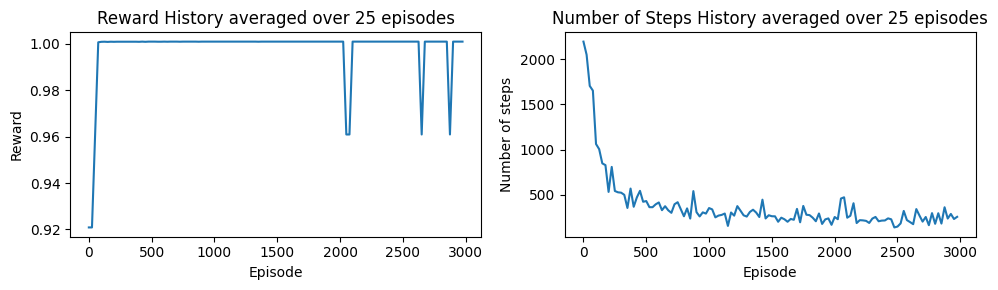




SARSA
Hyperparameters: (1, 0.99, 0.2)


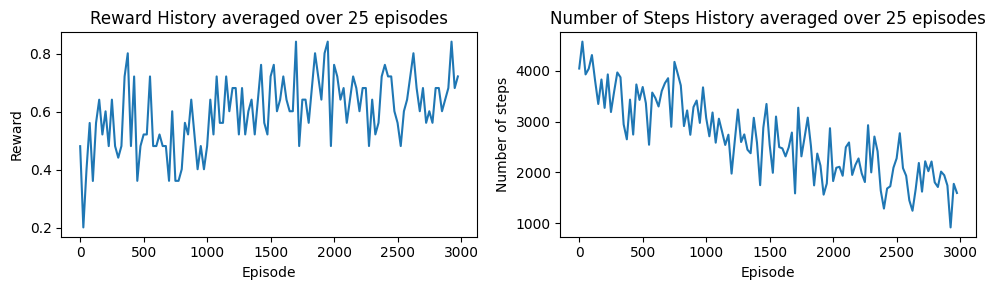




Q-learning
Hyperparameters: (1, 0.99, 0.2)


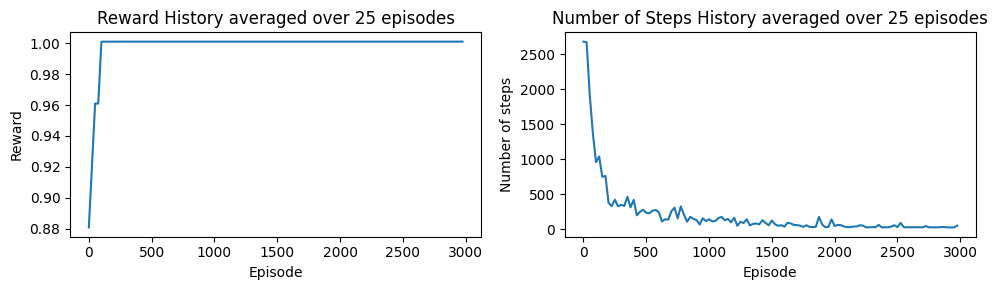

In [49]:
display_plots = True
# Display the reward and number of steps history for each set of hyperparameters
if display_plots:
    amount_to_avg = 25
    print("Monte Carlo Control")
    display_reward_and_steps_dict(reward_history_dict_mc_key, num_steps_history_dict_mc_key, amount_to_avg=amount_to_avg)
    print("\nSARSA")
    display_reward_and_steps_dict(reward_history_dict_sarsa_key, num_steps_history_dict_sarsa_key, amount_to_avg=amount_to_avg)
    print("\nQ-learning")
    display_reward_and_steps_dict(reward_history_dict_q_learning_key, num_steps_history_dict_q_learning_key, amount_to_avg=amount_to_avg)

- choose the best hyperparameters for each algorithm

In [50]:
# Get the best policy for each algorithm
best_policy_mc_key, best_avg_reward_mc_key, best_avg_steps_mc_key, best_avg_done_mc_key, best_key_mc_key = get_best_policy_from_policy_dict(
    key_env, policy_dict_mc_key, num_episodes=100, max_steps=1000
)
best_policy_sarsa_key, best_avg_reward_sarsa_key, best_avg_steps_sarsa_key, best_avg_done_sarsa_key, best_key_sarsa_key = get_best_policy_from_policy_dict(
    key_env, policy_dict_sarsa_key, num_episodes=100, max_steps=1000
)
best_policy_q_learning_key, best_avg_reward_q_learning_key, best_avg_steps_q_learning_key, best_avg_done_q_learning_key, best_key_q_learning_key = get_best_policy_from_policy_dict(
    key_env, policy_dict_q_learning_key, num_episodes=100, max_steps=1000
)

# Print the best hyperparameters for each algorithm
print("Monte Carlo Control")
print(f"Best hyperparameters: {best_key_mc_key} = (epsilon, gamma)")
print(f"Best average reward: {best_avg_reward_mc_key}")
print(f"Best average number of steps: {best_avg_steps_mc_key}")
print(f"Best average done: {best_avg_done_mc_key}")
print("\nSARSA")
print(f"Best hyperparameters: {best_key_sarsa_key} = (epsilon, gamma, alpha)")
print(f"Best average reward: {best_avg_reward_sarsa_key}")
print(f"Best average number of steps: {best_avg_steps_sarsa_key}")
print(f"Best average done: {best_avg_done_sarsa_key}")
print("\nQ-learning")
print(f"Best hyperparameters: {best_key_q_learning_key} = (epsilon, gamma, alpha)")
print(f"Best average reward: {best_avg_reward_q_learning_key}")
print(f"Best average number of steps: {best_avg_steps_q_learning_key}")
print(f"Best average done: {best_avg_done_q_learning_key}")

Monte Carlo Control
Best hyperparameters: (1, 0.99) = (epsilon, gamma)
Best average reward: 0.18
Best average number of steps: 822.94
Best average done: 0.18

SARSA
Best hyperparameters: (1, 0.99, 0.2) = (epsilon, gamma, alpha)
Best average reward: 0.58
Best average number of steps: 435.68
Best average done: 0.58

Q-learning
Best hyperparameters: (1, 0.99, 0.2) = (epsilon, gamma, alpha)
Best average reward: 1.0
Best average number of steps: 22.99
Best average done: 1.0


- show inference on the best policy for each algorithm

In [51]:
# Show video example of the best MC key policy
video_filename_mc_key = '/content/mc_key.mp4'
done, total_reward, num_steps = infer_goal_with_video(key_env, best_policy_mc_key, video_filename=video_filename_mc_key)
print(f"Monte Carlo Control with Epsilon-Greedy policy: Done={done}, Total Reward={total_reward}, Number of Steps={num_steps}")
embed_mp4(video_filename_mc_key)

Monte Carlo Control with Epsilon-Greedy policy: Done=False, Total Reward=0, Number of Steps=999


In [41]:
# Show video example of the best SARSA key policy
video_filename_sarsa_key = '/content/sarsa_key.mp4'
done, total_reward, num_steps = infer_goal_with_video(key_env, best_policy_sarsa_key, video_filename=video_filename_sarsa_key)
print(f"SARSA: Done={done}, Total Reward={total_reward}, Number of Steps={num_steps}")
embed_mp4(video_filename_sarsa_key)

SARSA: Done=True, Total Reward=1, Number of Steps=33


In [33]:
# Show video example of the best Q-learning key policy
video_filename_q_learning_key = '/content/q_learning_key.mp4'
done, total_reward, num_steps = infer_goal_with_video(key_env, best_policy_q_learning_key, video_filename=video_filename_q_learning_key)
print(f"Q-learning: Done={done}, Total Reward={total_reward}, Number of Steps={num_steps}")
embed_mp4(video_filename_q_learning_key)

Q-learning: Done=True, Total Reward=1, Number of Steps=21


- compare best policies for each algorithm and choose the best one

In [34]:
# put the best policies in a dictionary with the algorithm name and best hyperparameters as the key and policy as the value
best_policies_key = {
    ('Monte Carlo Control', best_key_mc_key): best_policy_mc_key,
    ('SARSA', best_key_sarsa_key): best_policy_sarsa_key,
    ('Q-learning', best_key_q_learning_key): best_policy_q_learning_key
}

# get the best policy from the dictionary
best_policy_key, best_avg_reward_key, best_avg_steps_key, best_avg_done_key, best_key_key = get_best_policy_from_policy_dict(
    key_env, best_policies_key, num_episodes=100, max_steps=1000
)

# Print the best hyperparameters for the best policy
print("Best Policy for Key Environment")
print(f"Best hyperparameters: {best_key_key} = (algorithm, hyperparameters)")
print(f"Best average reward: {best_avg_reward_key}")
print(f"Best average number of steps: {best_avg_steps_key}")
print(f"Best average done: {best_avg_done_key}")

Best Policy for Key Environment
Best hyperparameters: ('Q-learning', (1, 0.99, 0.2)) = (algorithm, hyperparameters)
Best average reward: 0.98
Best average number of steps: 41.9
Best average done: 0.98


# Best Policy for each Environment
- write the best policy for each environment
- Evaluate the best policy for each Environment
- Inference on the best policy for each Environment and show video of the agent in action

In [35]:
# print best policies for empty and key env
print("Best Policy for Empty Environment")
print(f"Best hyperparameters: {best_key_empty} = (algorithm, hyperparameters)")
print(f"Best average reward training: {best_avg_reward_empty}")
print(f"Best average number of steps training: {best_avg_steps_empty}")
print(f"Best average done training: {best_avg_done_empty}")


print("\nBest Policy for Key Environment")
print(f"Best hyperparameters: {best_key_key} = (algorithm, hyperparameters)")
print(f"Best average reward training: {best_avg_reward_key}")
print(f"Best average number of steps training: {best_avg_steps_key}")
print(f"Best average done training: {best_avg_done_key}")


# evaluate the best policy for the empty environment and print the results
avg_reward_empty, avg_steps_empty, avg_done_empty = evaluate_policy(empty_env, best_policy_empty, num_episodes=100, max_steps=1000)
print("\nEvaluation of the Best Policy for Empty Environment")
print(f"Average Reward Inference: {avg_reward_empty}")
print(f"Average Number of Steps Inference: {avg_steps_empty}")
print(f"Average Done Inference: {avg_done_empty}")

# evaluate the best policy for the key environment and print the results
avg_reward_key, avg_steps_key, avg_done_key = evaluate_policy(key_env, best_policy_key, num_episodes=100, max_steps=1000)
print("\nEvaluation of the Best Policy for Key Environment")
print(f"Average Reward Inference: {avg_reward_key}")
print(f"Average Number of Steps Inference: {avg_steps_key}")
print(f"Average Done Inference: {avg_done_key}")


Best Policy for Empty Environment
Best hyperparameters: ('SARSA', (1, 0.99, 0.2)) = (algorithm, hyperparameters)
Best average reward training: 1.0
Best average number of steps training: 8.59
Best average done training: 1.0

Best Policy for Key Environment
Best hyperparameters: ('Q-learning', (1, 0.99, 0.2)) = (algorithm, hyperparameters)
Best average reward training: 0.98
Best average number of steps training: 41.9
Best average done training: 0.98

Evaluation of the Best Policy for Empty Environment
Average Reward Inference: 1.0
Average Number of Steps Inference: 9.16
Average Done Inference: 1.0

Evaluation of the Best Policy for Key Environment
Average Reward Inference: 0.98
Average Number of Steps Inference: 41.94
Average Done Inference: 0.98


In [36]:
# show video of the best policy for the empty environment
video_filename_empty = '/content/empty.mp4'
done, total_reward, num_steps = infer_goal_with_video(empty_env, best_policy_empty, video_filename=video_filename_empty)
print(f"Empty Environment: Done={done}, Total Reward={total_reward}, Number of Steps={num_steps}")
embed_mp4(video_filename_empty)

Empty Environment: Done=True, Total Reward=1, Number of Steps=10


In [37]:
# show video of the best policy for the key environment
video_filename_key = '/content/key.mp4'
done, total_reward, num_steps = infer_goal_with_video(key_env, best_policy_key, video_filename=video_filename_key)
print(f"Key Environment: Done={done}, Total Reward={total_reward}, Number of Steps={num_steps}")
embed_mp4(video_filename_key)

Key Environment: Done=True, Total Reward=1, Number of Steps=19
